# -----------------PROYECTO FINAL-----------------

## 1. IMPORTAR LIBRERIAS

In [15]:
from keras.src.saving.saving_api import load_model
import cv2
import mediapipe as mp
import numpy as np
import os
import tensorflow as tf
import sys
import matplotlib.pyplot as plt

## 2. INICIALIZAR MEDIAPIPE

In [16]:
# Configuración inicial global
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=1
)
mp_draw = mp.solutions.drawing_utils

# Carpetas de señas
data_dir = "dataset_9"
data_dir_video = "dataset_9_videos"

model_path = "gesture_model.h5"
sequence_length = 30
total_landmarks = 126
gestures = []
X_mean = None
X_std = None



## Funciones principales

In [17]:
# Funciones principales
def init_system():
    global gestures
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(data_dir_video, exist_ok=True)
    gestures = get_existing_gestures()
    
def get_existing_gestures():
    return [d for d in os.listdir(data_dir) 
           if os.path.isdir(os.path.join(data_dir, d))]


## DETECCION DE MANO

In [18]:
'''def detect_hands():
    print("\nIniciando detección de manos. Presiona 'ESC' para salir.")
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        cv2.imshow("Detección de Manos", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()'''

'def detect_hands():\n    print("\nIniciando detección de manos. Presiona \'ESC\' para salir.")\n    cap = cv2.VideoCapture(0)\n\n    while True:\n        ret, frame = cap.read()\n        if not ret:\n            break\n\n        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)\n        results = hands.process(rgb_frame)\n\n        if results.multi_hand_landmarks:\n            for hand_landmarks in results.multi_hand_landmarks:\n                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)\n\n        cv2.imshow("Detección de Manos", frame)\n        if cv2.waitKey(1) & 0xFF == 27:\n            break\n\n    cap.release()\n    cv2.destroyAllWindows()'

In [19]:
# Funciones auxiliares
def process_frame(frame):
    """Procesa el frame para detectar manos con MediaPipe."""
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)
    return results

def extract_landmarks(hands_results, max_hands=2, landmarks_per_hand=21):
    """Extrae los landmarks de las manos detectadas y rellena con ceros si no se detectan manos."""
    landmarks = []
    if hands_results.multi_hand_landmarks:
        for hand_landmarks in hands_results.multi_hand_landmarks[:max_hands]:  # Limitar al número máximo de manos
            landmarks.extend([(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])
    
    # Rellenar con ceros si no se detectan suficientes manos
    expected_length = max_hands * landmarks_per_hand * 3  # 3 valores (x, y, z) por landmark
    if len(landmarks) < expected_length:
        landmarks.extend([(0.0, 0.0, 0.0)] * (expected_length - len(landmarks)))
    
    return landmarks

# Función para detectar manos en tiempo real
def detect_hands():
    print("\nIniciando detección de manos. Presiona 'ESC' para salir.")
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        results = process_frame(frame)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        cv2.imshow("Detección de Manos", frame)
        if cv2.waitKey(1) & 0xFF == 27:  # Presiona ESC para salir
            break

    cap.release()
    cv2.destroyAllWindows()

## RECOLLECION DE DATOS 

In [20]:
'''def collect_data():
    global gestures
    gesture = input("\nIngrese la palabra o letra para la cual desea recolectar datos: ").upper()
    num_sequences = int(input("Ingrese el número de secuencias a capturar (recomendado: 50): "))
    
    save_dir = os.path.join(dataset_dir, gesture)
    os.makedirs(save_dir, exist_ok=True)

    print(f"\nRecolectando datos para el gesto '{gesture}'. Presiona 'ESC' para cancelar.")
    print("Mantenga la seña frente a la cámara...")
    
    cap = cv2.VideoCapture(0)
    sequence = []
    counter = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            all_landmarks = []
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    all_landmarks.extend([lm.x, lm.y, lm.z])
            
            if len(results.multi_hand_landmarks) < 2:
                all_landmarks += [0.0] * 63
            
            sequence.append(all_landmarks)
            
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        if len(sequence) == sequence_length:
            np.save(os.path.join(save_dir, f"secuencia_{counter}.npy"), sequence)
            counter += 1
            sequence = []
            print(f"Secuencias capturadas: {counter}/{num_sequences}")

        cv2.imshow("Recolección de Datos", frame)
        if cv2.waitKey(1) & 0xFF == 27 or counter >= num_sequences:
            break

    cap.release()
    cv2.destroyAllWindows()
    gestures = get_existing_gestures()
    print(f"\nSe recolectaron {counter} secuencias para el gesto '{gesture}'")'''

'def collect_data():\n    global gestures\n    gesture = input("\nIngrese la palabra o letra para la cual desea recolectar datos: ").upper()\n    num_sequences = int(input("Ingrese el número de secuencias a capturar (recomendado: 50): "))\n    \n    save_dir = os.path.join(dataset_dir, gesture)\n    os.makedirs(save_dir, exist_ok=True)\n\n    print(f"\nRecolectando datos para el gesto \'{gesture}\'. Presiona \'ESC\' para cancelar.")\n    print("Mantenga la seña frente a la cámara...")\n    \n    cap = cv2.VideoCapture(0)\n    sequence = []\n    counter = 0\n\n    while True:\n        ret, frame = cap.read()\n        if not ret:\n            break\n\n        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)\n        results = hands.process(rgb_frame)\n\n        if results.multi_hand_landmarks:\n            all_landmarks = []\n            for hand in results.multi_hand_landmarks[:2]:\n                for lm in hand.landmark:\n                    all_landmarks.extend([lm.x, lm.y, lm.z])\

In [21]:
'''import cv2
import numpy as np
import os
import mediapipe as mp

# Configuración inicial global
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=1
)
mp_draw = mp.solutions.drawing_utils

def process_frame(frame):
    """Procesa el frame para detectar manos con MediaPipe."""
    results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return results

def extract_landmarks(hands_results):
    """Extrae los landmarks de las manos detectadas."""
    landmarks = []
    if hands_results.multi_hand_landmarks:
        for hand_landmarks in hands_results.multi_hand_landmarks:
            landmarks.extend([(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])
    return landmarks

def collect_data(data_dir_video, data_dir, sign_name, sequence_length):
    """Recolecta secuencias de movimiento para una seña específica y guarda el video de los landmarks."""
    sign_dir = os.path.join(data_dir, sign_name)
    sign_dir_video = os.path.join(data_dir_video, f"{sign_name}")
    os.makedirs(sign_dir, exist_ok=True)
    os.makedirs(sign_dir_video, exist_ok=True)

    cap = cv2.VideoCapture(0)  # Cambiar índice si usas DroidCam u otra cámara
    if not cap.isOpened():
        print("Error: No se pudo abrir la cámara")
        return

    total_sequences = int(input("Número de secuencias a recolectar (recomendado: 20-30): "))

    print("\nInstrucciones:")
    print(f"1. Cada secuencia grabará {sequence_length} frames de movimiento")
    print("2. Presiona ESPACIO para iniciar cada secuencia")
    print("3. Realiza el movimiento completo de la seña")
    print("4. La grabación se detendrá automáticamente")
    print("5. Presiona ESC para cancelar")

    sequence_count = 0
    frame_count = 0
    is_recording = False
    current_sequence = []

    # Configuración para guardar el video
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fps = 30  # Puedes ajustar los FPS según sea necesario
    video_writer = None

    while sequence_count < total_sequences:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        blank_frame = np.zeros_like(frame)
        hands_results = process_frame(frame)

        # Dibujar landmarks de las manos
        if hands_results.multi_hand_landmarks:
            for hand_landmarks in hands_results.multi_hand_landmarks:
                mp_draw.draw_landmarks(blank_frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Mostrar mensajes
        if is_recording:
            cv2.putText(frame, f"Grabando secuencia {sequence_count + 1}...", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            landmarks = extract_landmarks(hands_results)
            current_sequence.append(landmarks)
            frame_count += 1

            if frame_count >= sequence_length:
                # Guardar la secuencia de landmarks
                sequence_data = np.array(current_sequence)
                np.save(os.path.join(sign_dir, f"sequence_{sequence_count}.npy"), sequence_data)

                # Guardar el video
                video_writer.release()
                print(f"Secuencia {sequence_count + 1}/{total_sequences} guardada")
                sequence_count += 1
                frame_count = 0
                is_recording = False
                current_sequence = []

        cv2.imshow("Recolección de Datos", frame)
        cv2.imshow("Landmarks", blank_frame)

        key = cv2.waitKey(1) & 0xFF
        if key == 32 and not is_recording:  # Espacio para iniciar grabación
            is_recording = True
            current_sequence = []
            frame_count = 0
            # Inicializar el VideoWriter para guardar el video
            video_path = os.path.join(sign_dir_video, f"sequence_{sequence_count}.avi")
            video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))
        elif key == 27:  # ESC para salir
            break

        # Escribir el frame en el video si está grabando
        if is_recording:
            video_writer.write(frame)

    cap.release()
    if video_writer is not None:
        video_writer.release()
    cv2.destroyAllWindows()

# Ejemplo de uso
data_dir_video = "ruta/a/tu/carpeta/videos"
data_dir = "ruta/a/tu/carpeta/datos"
sign_name = "senal_ejemplo"
sequence_length = 30  # Número de frames por secuencia

collect_data(data_dir_video, data_dir, sign_name, sequence_length)'''

'import cv2\nimport numpy as np\nimport os\nimport mediapipe as mp\n\n# Configuración inicial global\nmp_hands = mp.solutions.hands\nhands = mp_hands.Hands(\n    static_image_mode=False,\n    max_num_hands=2,\n    min_detection_confidence=0.5,\n    min_tracking_confidence=0.5,\n    model_complexity=1\n)\nmp_draw = mp.solutions.drawing_utils\n\ndef process_frame(frame):\n    """Procesa el frame para detectar manos con MediaPipe."""\n    results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))\n    return results\n\ndef extract_landmarks(hands_results):\n    """Extrae los landmarks de las manos detectadas."""\n    landmarks = []\n    if hands_results.multi_hand_landmarks:\n        for hand_landmarks in hands_results.multi_hand_landmarks:\n            landmarks.extend([(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])\n    return landmarks\n\ndef collect_data(data_dir_video, data_dir, sign_name, sequence_length):\n    """Recolecta secuencias de movimiento para una seña específ

In [22]:
# Función para recolectar datos de gestos
def collect_data(data_dir_video, data_dir, sign_name, sequence_length):
    """Recolecta secuencias de movimiento para una seña específica y guarda el video de los landmarks."""
    sign_dir = os.path.join(data_dir, sign_name)
    sign_dir_video = os.path.join(data_dir_video, f"{sign_name}")
    os.makedirs(sign_dir, exist_ok=True)
    os.makedirs(sign_dir_video, exist_ok=True)

    cap = cv2.VideoCapture(0)  # Cambiar índice si usas DroidCam u otra cámara
    if not cap.isOpened():
        print("Error: No se pudo abrir la cámara")
        return

    total_sequences = int(input("Número de secuencias a recolectar (recomendado: 20-30): "))

    print("\nInstrucciones:")
    print(f"1. Cada secuencia grabará {sequence_length} frames de movimiento")
    print("2. Presiona ESPACIO para iniciar cada secuencia")
    print("3. Realiza el movimiento completo de la seña")
    print("4. La grabación se detendrá automáticamente")
    print("5. Presiona ESC para cancelar")

    sequence_count = 0
    frame_count = 0
    is_recording = False
    current_sequence = []

    # Configuración para guardar el video
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fps = 30  # Puedes ajustar los FPS según sea necesario
    video_writer = None

    while sequence_count < total_sequences:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        blank_frame = np.zeros_like(frame)
        hands_results = process_frame(frame)

        # Dibujar landmarks de las manos
        if hands_results.multi_hand_landmarks:
            for hand_landmarks in hands_results.multi_hand_landmarks:
                mp_draw.draw_landmarks(blank_frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Mostrar mensajes
        if is_recording:
            cv2.putText(blank_frame, f"Grabando secuencia {sequence_count + 1}...", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            landmarks = extract_landmarks(hands_results)
            current_sequence.append(landmarks)
            frame_count += 1

            if frame_count >= sequence_length:
                # Guardar la secuencia de landmarks
                sequence_data = np.array(current_sequence)
                np.save(os.path.join(sign_dir, f"sequence_{sequence_count}.npy"), sequence_data)

                # Guardar el video
                video_writer.release()
                print(f"Secuencia {sequence_count + 1}/{total_sequences} guardada")
                sequence_count += 1
                frame_count = 0
                is_recording = False
                current_sequence = []

        cv2.imshow("Recolección de Datos", frame)  # Mostrar el video original
        cv2.imshow("Landmarks", blank_frame)  # Mostrar los landmarks

        key = cv2.waitKey(1) & 0xFF
        if key == 32 and not is_recording:  # Espacio para iniciar grabación
            is_recording = True
            current_sequence = []
            frame_count = 0
            # Inicializar el VideoWriter para guardar el video
            video_path = os.path.join(sign_dir_video, f"sequence_{sequence_count}.avi")
            video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))
        elif key == 27:  # ESC para salir
            break

        # Escribir el frame en el video si está grabando
        if is_recording:
            video_writer.write(blank_frame)  # Guardar solo los landmarks

    cap.release()
    if video_writer is not None:
        video_writer.release()
    cv2.destroyAllWindows()

## CARGA DE DATOS

In [23]:
def load_data():
    X = []
    y = []
    
    for label_idx, gesture in enumerate(gestures):
        gesture_dir = os.path.join(data_dir, gesture)
        sequences = [f for f in os.listdir(gesture_dir) if f.endswith('.npy')]
        
        for seq_file in sequences:
            seq_path = os.path.join(gesture_dir, seq_file)
            sequence = np.load(seq_path)
            
            if sequence.shape == (sequence_length, total_landmarks):
                X.append(sequence)
                y.append(label_idx)
    
    return np.array(X), np.array(y), gestures


## ENTRENAMIENTO DEL MODELO

In [24]:
def train_model():
    global X_mean, X_std, gestures
    if not gestures:
        print("\nNo hay datos recolectados. Primero recolecte datos de gestos.")
        return

    print("\nCargando datos y preparando el entrenamiento...")
    X, y, gestures = load_data()
    y = tf.keras.utils.to_categorical(y)

    X_mean = np.mean(X, axis=(0, 1))
    X_std = np.std(X, axis=(0, 1))
    X = (X - X_mean) / X_std

    inputs = tf.keras.Input(shape=(sequence_length, total_landmarks))
    x = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu', 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    outputs = tf.keras.layers.Dense(len(gestures), activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nIniciando entrenamiento...")
    history = model.fit(
        X, y,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )
    model.save(model_path)
    print(f"\nModelo guardado en {model_path}")
    
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Precisión de validación final: {val_accuracy:.2%}")

    # Visualización del entrenamiento
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de validación')
    plt.title('Precisión del Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title('Pérdida del Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

## EVALUACION DEL MODELO

In [25]:
def evaluate():
    if not os.path.exists(model_path):
        print("\nPrimero debe entrenar el modelo.")
        return
    
    if X_mean is None or X_std is None:
        print("\nERROR: Debe entrenar el modelo primero para obtener los parámetros de normalización")
        return

    model = load_model(model_path)
    print("\nCargando modelo y preparando evaluación...")
    
    sequence = []
    cap = cv2.VideoCapture(0)
    
    print("\nMostrando predicciones en tiempo real. Presiona 'ESC' para salir.")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)
        
        if results.multi_hand_landmarks:
            all_landmarks = []
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    all_landmarks.extend([lm.x, lm.y, lm.z])
            
            if len(results.multi_hand_landmarks) < 2:
                all_landmarks += [0.0] * 63
            
            sequence.append(all_landmarks)
            
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        else:
            sequence = []
        
        sequence = sequence[-sequence_length:]
        
        if len(sequence) == sequence_length:
            try:
                seq_array = np.array(sequence)
                seq_array = (seq_array - X_mean) / X_std
                input_data = seq_array.reshape(1, sequence_length, total_landmarks)
                
                prediction = model.predict(input_data, verbose=0)[0]
                predicted_class = np.argmax(prediction)
                confidence = np.max(prediction)
                
                if confidence > 0.8:
                    gesture = gestures[predicted_class]
                    cv2.putText(frame, f"{gesture} ({confidence:.2%})", (10, 50),
                              cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            except Exception as e:
                print(f"\nError en predicción: {str(e)}")
                break

        cv2.imshow("Predicciones en Tiempo Real", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

## REENTRENAR GESTO

In [26]:
def retrain_gesture():
    global gestures
    if not gestures:
        print("\nNo hay gestos para reentrenar. Primero recolecte datos.")
        return

    print("\nGestos disponibles para reentrenar:")
    for i, gesture in enumerate(gestures):
        print(f"{i+1}. {gesture}")

    try:
        choice = int(input("\nSeleccione el número del gesto a reentrenar: ")) - 1
        if 0 <= choice < len(gestures):
            gesture = gestures[choice]
            gesture_dir = os.path.join(data_dir, gesture)
            
            for file in os.listdir(gesture_dir):
                os.remove(os.path.join(gesture_dir, file))
            
            print(f"\nDatos anteriores de '{gesture}' eliminados.")
            collect_data()
            train_model()
        else:
            print("\nSelección inválida.")
    except ValueError:
        print("\nPor favor, ingrese un número válido.")

## MENU

In [ ]:
# Menú principal
def main():
    init_system()
    
    while True:
        print("\n=== Sistema de Reconocimiento de Lenguaje de Señas ===")
        print("1. Detectar Manos")
        print("2. Recolectar Datos")
        print("3. Entrenar Modelo")
        print("4. Evaluar")
        print("5. Reentrenar Gesto")
        print("6. Salir")
        
        choice = input("\nSeleccione una opción: ")
        
        if choice == '1':
            detect_hands()
        elif choice == '2':
            sign_name = input("Nombre de la seña a recolectar: ")
            collect_data(data_dir_video, data_dir, sign_name, sequence_length)
        elif choice == '3':
            train_model()
        elif choice == '4':
            evaluate()
        elif choice == '5':
            retrain_gesture()
        elif choice == '6':
            print("\n¡Hasta luego!")
            break
        else:
            print("\nOpción inválida. Por favor, intente de nuevo.")

# MENU


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo
4. Evaluar
5. Reentrenar Gesto
6. Salir

Cargando datos y preparando el entrenamiento...

Iniciando entrenamiento...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.3061 - loss: 2.4402 - val_accuracy: 0.0000e+00 - val_loss: 2.6374
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5827 - loss: 2.1972 - val_accuracy: 0.0000e+00 - val_loss: 2.6272
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8372 - loss: 2.0192 - val_accuracy: 0.0000e+00 - val_loss: 2.6113
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8677 - loss: 1.9030 - val_accuracy: 0.0000e+00 - val_loss: 2.5902
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9050 - loss: 1.7817 - val_accuracy: 0.0000e+00 - val_loss: 2.5739
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9244 - loss: 1.6447 - val_accuracy: 0.0000e+00 - val_loss: 2.


Modelo guardado en gesture_model.h5
Precisión de validación final: 100.00%


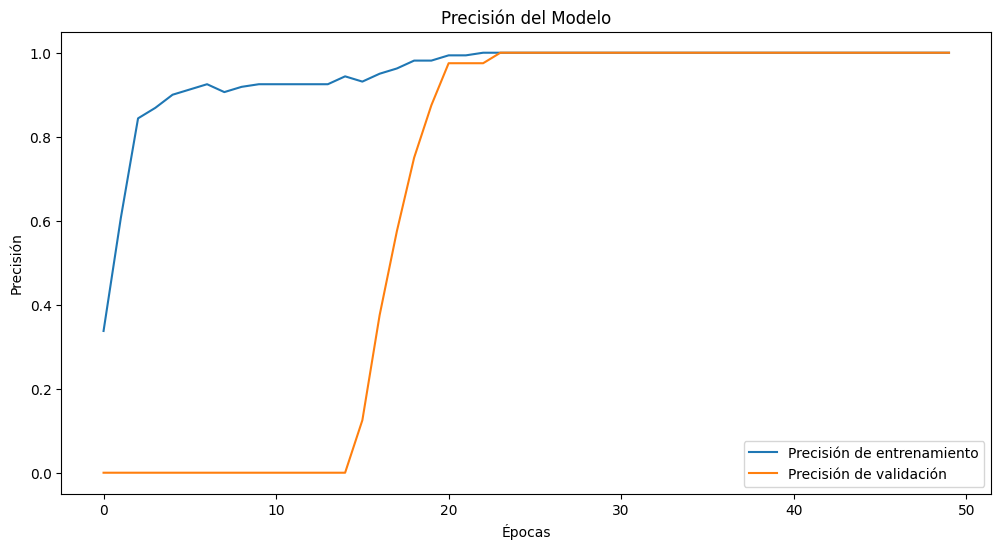

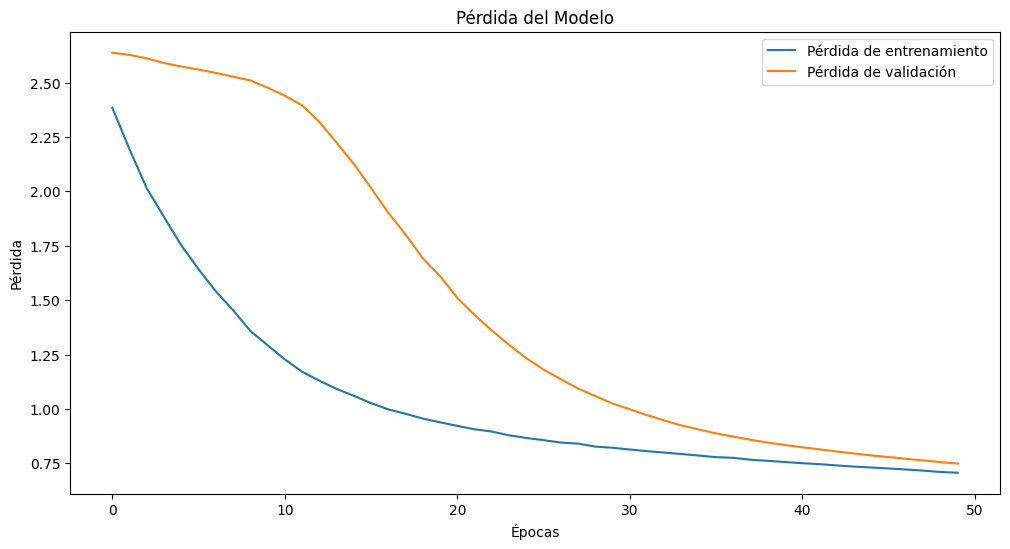


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo
4. Evaluar
5. Reentrenar Gesto
6. Salir

Instrucciones:
1. Cada secuencia grabará 30 frames de movimiento
2. Presiona ESPACIO para iniciar cada secuencia
3. Realiza el movimiento completo de la seña
4. La grabación se detendrá automáticamente
5. Presiona ESC para cancelar
Secuencia 1/5 guardada
Secuencia 2/5 guardada
Secuencia 3/5 guardada
Secuencia 4/5 guardada
Secuencia 5/5 guardada

=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo
4. Evaluar
5. Reentrenar Gesto
6. Salir

¡Hasta luego!


In [28]:
if __name__ == "__main__":
    main()